### Find a learning rate 

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
import sys
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Input, Activation, Dropout, Flatten, Dense, add
from tensorflow.keras.utils  import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import SGD
import tempfile 
import matplotlib.pyplot as plt 

%matplotlib inline

In [3]:
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = '/home/sanchit/Documents/Projects/datasets/fire_and_smoke_data/train/'
validation_data_dir = '/home/sanchit/Documents/Projects/datasets/fire_and_smoke_data/val/'
nb_train_samples = 2400
nb_validation_samples = 490
epochs = 30
batch_size = 32

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### build a network - copy and paste your networ

In [5]:
model = Sequential()
input_shape = (img_width, img_height, 3)
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

### compile a model

In [6]:
sgd = SGD(momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

### load data into memory

In [7]:
def load_data(dir_path="", class_mode='binary', classes=None):
    """
    loads all the images for all the classes (sub-dirs) provided in the input directory.
    :param dir_path -  input directory which contains for each class a sub-directory. 
    :param class_mode - binary (for usage in binary_crossentropy loss) and categorical (categorical_crossentropy loss)
    :params classes - a list of classes'names 
    """
    X = []
    y = []
    data_kind = dir_path.split("/")[-2] # either training or validation or testing
    directories=[d for d in os.listdir(dir_path) if os.path.isdir(d) or (not d.startswith("."))]
    
    for label, class_name in enumerate(directories):
        print(f"loading {data_kind} data for class: {class_name}")
        class_dir = os.path.join(dir_path, class_name)
        for img_path in tqdm(glob(class_dir + '/*.jpg')):
            img = load_img(img_path, target_size=(img_width, img_height))
            img = img_to_array(img)

            # save the image and its corresponding label
            X.append(img)
            y.append(label)
                
    X = np.asarray(X, dtype=np.float32) / 255.0
    y = np.asarray(y)
    
    if class_mode == "categorical":
        y = to_categorical(y_train, num_classes=classes)
        
    print(f"total number of images loaded: {X.shape[0]} and of shape: {X.shape[1:]}")
    
    return X, y

In [8]:
X_train, y_train = load_data(dir_path=train_data_dir)

  2%|▏         | 22/1200 [00:00<00:05, 205.84it/s]

loading train data for class: fire


 35%|███▍      | 418/1200 [00:03<00:06, 129.80it/s]/home/sanchit/miniconda3/envs/tf2.1/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  2%|▏         | 21/1200 [00:00<00:05, 196.69it/s]

loading train data for class: no_fire


100%|██████████| 1200/1200 [00:09<00:00, 132.35it/s]


total number of images loaded: 2400 and of shape: (224, 224, 3)


In [9]:
# create a train generator
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    vertical_flip=True,
    rotation_range=30,
    fill_mode="wrap",
    height_shift_range=0.15,
    width_shift_range=0.15)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

### Find the best learning rates range

In [10]:
class LearningRateFinder:
    """ Objective is to find a best learning rate by plotting various losses against a list of learning 
    rates which range from very high to very low. Optimal LR should lie somewhere inside of this range. 
    
    Starting and ending LRs which are chosen are too low (where network is unable to learn, thus a high 
    loss and too high (where loss is also high), respectively). Therefore, a good range of min and max LR 
    bounds should be somewhere inside of this range and finding that good range is the objective of this class. 
    
    At the end, entire network can be then trained by using either the correct LR (min LR) or min and max LRs 
    with a Cyclic LR scheduler. 
    
    Reference: https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/
    """
    def __init__(self, model, stopFactor=4, beta=0.98):
        """ initializes variables for finding the LRs 
            
            :param model: model for which LRs and losses are plotted and analyzed 
            :param stopFactor: stop factor when the LR becomes too large, then stop the model training automatically 
            :param beta: used for averaging the loss value 
            :param lrs: a list of tried LR values 
            :param losses: a list of tried loss values 
            :param avgLoss: average loss value over time 
            :param batchNum: current batch number 
            :param bestLoss: best loss (of course, lowest) found so far during training 
            :param lrMult: LR multiplication factor 
            :weightsFile: filename to save initial (original) weights of the model 
        """
        
        # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta

        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []

        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def reset(self):
        # re-initialize all variables from our constructor
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def is_data_iter(self, data):
        # define the set of class types we will check for
        iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
             "DataFrameIterator", "Iterator", "Sequence"]

        # return whether our data is an iterator
        return data.__class__.__name__ in iterClasses

    def on_batch_end(self, batch, logs):
        """ following are the steps/things which is happening in this function:
            - this function runs after every batch update 
            - recording of current loss values which is smoothen up first 
            - recording of best loss and updating of it if a new one has been found 
            - checking if the loss has grown too much, then stop the model training 
            - setting up of a new LR for the next model training with multiplying current 
              LR with the LR-multiplier at every batch update
        """
        
        
        # get the current LR from the model and save to a list of LRs which have been used already 
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"] # NOTE: it contains the current loss of the training
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)

        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss

        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return

        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth

        # increase the learning rate ans set it as a new LR for the model training 
        lr *= self.lrMult # self.lrMult is found in the find() method
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, trainData, startLR, endLR, epochs=None,
        stepsPerEpoch=None, batchSize=32, sampleSize=2048,
        classWeight=None, verbose=1):
        """ following are the steps/things which is happening in this function:
            - only using the training data for computing the loss, i.e., no split of it into test/val data 
            - loss log are transferred via LambdaCallback function to "on_batch_end()" fn. 
            - LR multiplier is computed once. And, it is a fixed (uniform) interval computed from endLR, startLR 
                over total numbers of batches 
            - Model's original weights and LR are temporarily saved and they get imported back again after 
              the plot for finding the best LR is done. 
        """
        
        # reset our class-specific variables
        self.reset()

        # determine if we are using a data generator or not
        useGen = self.is_data_iter(trainData)

        # if we're using a generator and the steps per epoch is not
        # supplied, raise an error
        if useGen and stepsPerEpoch is None:
            msg = "Using generator without supplying stepsPerEpoch"
            raise Exception(msg)

        # if we're not using a generator then our entire dataset must
        # already be in memory
        elif not useGen:
            # grab the number of samples in the training data and
            # then derive the number of steps per epoch
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))

        # if no number of training epochs are supplied, compute the
        # training epochs based on a default sample size
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch

        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

        # save the model's original weights, so we can reset the weights when we are 
        # done finiding the optimal learning rates 
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)

        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)

        # construct a callback that will be called at the end of each
        # batch, enabling us to increase our learning rate as training
        # progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))

        # check to see if we are using a data iterator
        if useGen:
            self.model.fit_generator(
                trainData,
                steps_per_epoch=stepsPerEpoch,
                epochs=epochs,
                class_weight=classWeight,
                verbose=verbose,
                callbacks=[callback],
                workers=8)

        # otherwise, our entire training data is already in memory
        else:
            # train our model using Keras' fit method
            self.model.fit(
                trainData[0], trainData[1],
                batch_size=batchSize,
                epochs=epochs,
                class_weight=classWeight,
                callbacks=[callback],
                verbose=verbose,
                workers=8)

        # finally, when we are done, set back the original model's weights and LR values 
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)

    def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]

        # plot the learning rate vs. loss
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")

        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 75 steps
Epoch 1/30
75/75 [==============================] - 4s 52ms/step - loss: 0.6918 - accuracy: 0.5171
Epoch 2/30
75/75 [==============================] - 3s 42ms/step - loss: 0.6924 - accuracy: 0.5096
Epoch 3/30
75/75 [==============================] - 3s 41ms/step - loss: 0.6920 - accuracy: 0.5063
Epoch 4/30
75/75 [==============================] - 3s 42ms/step - loss: 0.6918 - accuracy: 0.5063
Epoch 5/30
75/75 [==============================] - 3s 43ms/step - loss: 0.6922 - accuracy: 0.5163
Epoch 6/30
75/75 [==============================] - 3s 41ms/step - loss: 0.6919 - accuracy: 0.5163
Epoch 7/30
75/75 [==============================] - 3s 42ms/step - loss: 0.6929 - accuracy: 0.5121
Epoch 8/30
75/75 [==============================] - 3s 42ms/step - loss: 0.6924 - accuracy: 0.5058
Epoch 9/30
75/75 [==============================] - 3s 41ms/step - loss: 0.6922 - accura

SystemExit: 0

/home/sanchit/miniconda3/envs/tf2.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


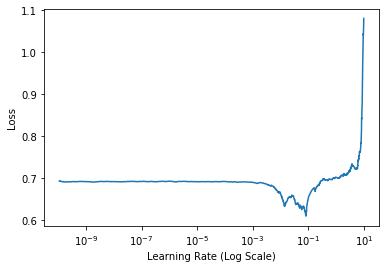

In [11]:
lrf = LearningRateFinder(model)
# increasing learning rates at a regular interval from a very low to very high range. Then, compute 
# the training loss. Objective here is to find a range of LRs where the loss varies the most. That means in those 
# LRs model is the learning the most. 
lrf.find(train_generator, 
        startLR=1e-10, 
        endLR=1e+1, 
        epochs=30,
        stepsPerEpoch=nb_train_samples // batch_size, 
        batchSize=batch_size)

# plot the loss for the various learning rates and save the
# resulting plot to disk
lrf.plot_loss()
#plt.savefig(LR_LOSS_PLOT_PATH)

# exit the script so we can adjust our learning rates
# in the config and then train the network for our full set of
# epochs
print("[INFO] learning rate finder complete")
print("[INFO] examine plot and adjust learning rates before training")
sys.exit(0)

In [ ]:
# def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
#     def eraser(input_img):
#         img_h, img_w, img_c = input_img.shape
#         p_1 = np.random.rand()

#         if p_1 > p:
#             return input_img

#         while True:
#             s = np.random.uniform(s_l, s_h) * img_h * img_w
#             r = np.random.uniform(r_1, r_2)
#             w = int(np.sqrt(s / r))
#             h = int(np.sqrt(s * r))
#             left = np.random.randint(0, img_w)
#             top = np.random.randint(0, img_h)

#             if left + w <= img_w and top + h <= img_h:
#                 break

#         if pixel_level:
#             c = np.random.uniform(v_l, v_h, (h, w, img_c))
#         else:
#             c = np.random.uniform(v_l, v_h)

#         input_img[top:top + h, left:left + w, :] = c

#         return input_img

#     return eraser